In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.linear_model import Lasso

In [2]:
walkable_cities = pd.read_csv("walkable-cities.csv")

In [3]:
#uses the loc method to select the subset of rows and columns where the column names are not duplicated. 
walkable_cities = walkable_cities.loc[:,~walkable_cities.columns.duplicated()]
#removes the specified columns from the walkable_cities dataframe
walkable_cities.drop(walkable_cities.columns[[4,5,6,7,11]], axis=1, inplace=True)
walkable_cities

,place_code,city,state,pop_estimate_2021,geo_code,land_area_sqkm,pop_per_km2,median_age,male,female,...,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime,walkable
0,3076,Auburn,Alabama,78564,103076.0,157.084761,500.137630,27.8,0.483186,0.516662,...,79325.0,29770.0,48531.0,32556.0,0.231926,NaN,NaN,NaN,NaN,car dependent
1,7000,Birmingham,Alabama,197575,107000.0,380.801025,518.840515,37.2,0.479291,0.514812,...,58012.0,27211.0,36614.0,36193.0,0.270712,7.4,51.0,NaN,NaN,car dependent
2,20104,Decatur,Alabama,57804,120104.0,140.785624,410.581694,NaN,NaN,NaN,...,NaN,NaN,NaN,31259.0,NaN,NaN,39.0,NaN,NaN,car dependent
3,21184,Dothan,Alabama,71175,121184.0,232.650562,305.930918,40.5,0.473565,0.527952,...,70513.0,31168.0,45088.0,31803.0,0.209933,5.3,NaN,NaN,NaN,car dependent
4,35896,Hoover,Alabama,92589,135896.0,124.490626,743.742746,38.9,0.504066,0.495923,...,124562.0,50046.0,99276.0,36193.0,0.059813,3.5,51.0,0.001231,0.020758,car dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,66000,Racine,Wisconsin,77127,5566000.0,40.080067,1924.323130,34.6,0.476954,0.523098,...,60267.0,24591.0,47861.0,33541.0,0.221427,6.4,43.0,0.003773,0.012836,walkable
756,84250,Waukesha,Wisconsin,71256,5584250.0,66.102904,1077.955667,36.2,0.482654,0.517318,...,88781.0,38381.0,69533.0,34586.0,0.077860,NaN,43.0,0.000940,0.009683,car dependent
757,85300,West Allis,Wisconsin,59484,5585300.0,29.477371,2017.954722,NaN,NaN,NaN,...,NaN,NaN,NaN,34586.0,NaN,NaN,45.0,0.003547,0.028344,walkable
758,13150,Casper,Wyoming,58656,5613150.0,68.757037,853.090863,NaN,NaN,NaN,...,NaN,NaN,NaN,30785.0,NaN,NaN,42.0,0.002881,0.028590,car dependent


In [4]:
data = walkable_cities[['pop_estimate_2021',
       'land_area_sqkm', 'pop_per_km2', 'median_age', 'male', 'female',
       'white_alone', 'black_or_african_american_alone',
       'american_indian_and_alaska_native_alone', 'asian_alone',
       'native_hawaiian_and_other_pacific_islander_alone',
       'some_other_race_alone', 'two_or_more_races', 'hispanic_or_latino',
       'access2', 'arthritis', 'binge', 'bphigh', 'bpmed', 'cancer', 'casthma',
       'cervical', 'chd', 'checkup', 'cholscreen', 'colon_screen', 'copd',
       'corem', 'corew', 'csmoking', 'dental', 'depression', 'diabetes',
       'ghlth', 'highchol', 'kidney', 'lpa', 'mammouse', 'mhlth', 'obesity',
       'phlth', 'sleep', 'stroke', 'teethlost', 'cumulative_confirmed',
       'cumulative_deceased', 'walk_score', 'bike_score', 'drive_commute',
       'public_transit_commute', 'walk_commute', 'bike_commute',
       'work_from_home', 'households', 'mean_household_income', 'mean_income',
       'median_household_income', 'living_wage', 'poverty',
       'unemployment_rate', 'median_aqi', 'violent_crime', 'property_crime']]

data.head()

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
0,78564,157.084761,500.137630,27.8,0.483186,0.516662,0.622652,0.178313,0.003029,0.094369,...,0.370857,79325.0,29770.0,48531.0,32556.0,0.231926,NaN,NaN,NaN,NaN
1,197575,380.801025,518.840515,37.2,0.479291,0.514812,0.238942,0.694906,0.003821,0.016576,...,0.443224,58012.0,27211.0,36614.0,36193.0,0.270712,7.4,51.0,NaN,NaN
2,57804,140.785624,410.581694,NaN,NaN,NaN,0.574182,0.232527,0.007491,0.009186,...,NaN,NaN,NaN,NaN,31259.0,NaN,NaN,39.0,NaN,NaN
3,71175,232.650562,305.930918,40.5,0.473565,0.527952,0.568964,0.335736,0.004004,0.016031,...,0.425725,70513.0,31168.0,45088.0,31803.0,0.209933,5.3,NaN,NaN,NaN
4,92589,124.490626,743.742746,38.9,0.504066,0.495923,0.687598,0.168713,0.002743,0.064036,...,0.396602,124562.0,50046.0,99276.0,36193.0,0.059813,3.5,51.0,0.001231,0.020758


In [5]:
data.describe()

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
count,7.600000e+02,756.000000,756.000000,564.000000,564.000000,564.000000,755.000000,755.000000,755.000000,755.000000,...,563.000000,563.000000,564.000000,564.000000,727.000000,564.000000,518.000000,681.000000,633.000000,633.000000
mean,1.646429e+05,135.344888,1589.308126,36.554787,0.492196,0.508244,0.530158,0.136474,0.010493,0.082841,...,0.382859,97922.424512,37995.865248,73858.675532,38843.456671,0.135641,6.892085,47.157122,0.004210,0.025443
std,3.924743e+05,186.608511,1505.860211,4.354124,0.018344,0.017905,0.195627,0.153452,0.010476,0.107579,...,0.049541,33448.610008,13202.716289,26481.199768,6538.581192,0.061697,2.587433,17.362578,0.003196,0.012229
min,5.010400e+04,3.238030,93.047234,22.800000,0.427906,0.342966,0.025274,0.002961,0.001181,0.001917,...,0.245462,49626.000000,17236.000000,32217.000000,29353.000000,0.017209,1.300000,15.000000,0.000298,0.005378
25%,6.490600e+04,49.981347,797.451711,33.900000,0.480277,0.497261,0.398436,0.030277,0.004162,0.023772,...,0.352608,75498.000000,28768.500000,55021.250000,34211.500000,0.087817,5.100000,38.000000,0.001950,0.016792
50%,8.838150e+04,83.929773,1179.498942,36.550000,0.492517,0.508403,0.535662,0.076221,0.007370,0.044357,...,0.388017,89800.000000,35076.000000,67973.500000,37075.000000,0.129836,6.700000,42.000000,0.003531,0.023194
75%,1.378420e+05,142.740369,1820.268367,39.000000,0.503238,0.519734,0.689173,0.188963,0.013254,0.092825,...,0.417305,112246.500000,43269.250000,86506.000000,42241.000000,0.173281,8.300000,49.000000,0.005670,0.032411
max,8.467513e+06,1935.461994,19691.366525,51.000000,0.657102,0.571949,0.877240,0.912617,0.129305,0.727708,...,0.516764,268748.000000,102537.000000,205219.000000,64090.000000,0.421409,17.400000,122.000000,0.020618,0.086487


In [6]:
# Scaling - normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Create an imputer object with strategy='mean' or 'median'
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data using the imputer
data_scaled = imputer.fit_transform(data_scaled)

# Bootstrap the data_scaled to create 2000 rows
bootstrap = resample(data_scaled, n_samples=2000, replace=True, random_state=42)

# Convert the bootstrap sample to a dataframe
df = pd.DataFrame(bootstrap, columns=data.columns)


In [7]:
df.describe()

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
count,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,...,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2.000000e+03
mean,0.017678,0.024011,0.007619,-6.409799e-03,2.094262e-03,-3.504593e-03,0.010501,-0.005985,0.023937,-0.008811,...,-9.696635e-03,3.635366e-02,2.987291e-02,2.938074e-02,0.010115,-1.372082e-04,-4.179605e-02,-0.003180,-0.015008,-1.628228e-02
std,1.227741,1.065035,1.080125,9.046030e-01,8.245847e-01,8.264168e-01,0.971818,0.987066,1.073058,0.947474,...,8.551973e-01,9.166950e-01,9.092716e-01,9.079236e-01,0.976593,8.652831e-01,8.279010e-01,0.975548,0.899608,8.800931e-01
min,-0.292030,-0.708405,-0.994283,-3.161829e+00,-3.507698e+00,-9.239029e+00,-2.582561,-0.870636,-0.889475,-0.752721,...,-2.775851e+00,-1.445183e+00,-1.573789e+00,-1.573895e+00,-1.381289,-1.921268e+00,-2.163337e+00,-1.853455,-1.225133,-1.642090e+00
25%,-0.253962,-0.455370,-0.551436,-4.263622e-01,-3.866943e-01,-4.085665e-01,-0.618768,-0.694159,-0.597734,-0.548725,...,-3.314129e-01,-5.251648e-01,-5.130666e-01,-5.464824e-01,-0.692899,-4.977495e-01,-4.998521e-01,-0.527793,-0.643577,-6.104982e-01
50%,-0.192570,-0.274642,-0.277310,-8.818793e-16,-3.073979e-15,1.014161e-15,0.031049,-0.380885,-0.291785,-0.357435,...,1.060135e-15,-1.262065e-17,-2.393672e-16,-3.779483e-17,-0.201322,-8.818793e-17,-1.371704e-17,-0.239606,-0.059671,3.367501e-17
75%,-0.069629,0.049534,0.135250,3.551999e-01,3.670018e-01,3.730765e-01,0.785707,0.293638,0.271807,0.114607,...,4.631954e-01,1.726741e-01,9.317975e-02,2.261656e-01,0.519973,3.856403e-01,1.578048e-01,0.048581,0.229609,3.870930e-01
max,21.169126,9.652876,12.029033,3.320538e+00,8.997463e+00,3.561121e+00,1.775379,5.061244,11.349040,5.998349,...,2.705308e+00,5.111647e+00,4.892813e+00,4.964916e+00,3.863824,4.635877e+00,4.065060e+00,4.313754,5.137547,4.276784e+00


In [8]:
# Do the original interpolation
df.interpolate(method='nearest', xis=0, inplace=True)

# Function to curve fit to the data
def func(x, *params):
    y = 0
    for i in range(len(params)):
        y += params[i] * (x ** i)
    return y

# Initial parameter guess, just to kick off the optimization
guess = [1] * len(df.columns)

# Create copy of df to remove NaNs for curve fitting
fit_data = df.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_data.columns:
    # Get x & y
    x = fit_data.index.astype(float).values
    y = fit_data[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

# Extrapolate each column
for col in df.columns:
    # Get the index values for NaNs in the column
    x = df[pd.isnull(df[col])].index.astype(float).values
    # Iterate through each index value and set the value to the extrapolated result
    for idx in x:
        df.loc[idx, col] = func(idx, *col_params[col])

# Define the numerical columns
list_numerical = df.columns.drop('walk_score')

# Define the features and target variable
X = df.drop(columns='walk_score')
y = df['walk_score']

# Split the df set into train and test set with the first 70% of the df for training and the remaining 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

<ipython-input-8-61356a55c26f>:8: RuntimeWarning: invalid value encountered in multiply
  y += params[i] * (x ** i)


In [9]:
# standardize our features. We do this by subtracting the mean from our observations and then dividing the difference by the standard deviation.
scaler = StandardScaler().fit(X_train[list_numerical]) 
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

## LassoCV Linear Regression model

LassoCV is a type of linear regression model that uses L1 regularization. LassoCV performs Lasso
regression with cross-validation.

The model is initialized with a cv value of 5, meaning that it will use 5-fold cross-validation when
training.

Random_state is set to 0 for reproducibility and max_iter is set to 10000 to increase the number of 
iterations for convergence.

In [10]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit the model to the training data
model.fit(X_train, y_train)

# The best alpha value is chosen from the cross-validation process and used to create a new Lasso model
lasso_best = Lasso(alpha=model.alpha_)
#Fit this new Lasso model to the training data
lasso_best.fit(X_train, y_train)

c:\Users\daklu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.546e-01, tolerance: 1.428e-01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0007051944559964689)

In [11]:
# Create a list of feature importance tuples
feature_importance = list(zip(X.columns, lasso_best.coef_))

# Sort the feature importance list by coefficient in descending order
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Calculate R-squared and MSE
r2 = lasso_best.score(X_test, y_test)
y_pred = lasso_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Evaluate the model's performance on the training and test sets by printing the R-squared score
print(f"R-squared test set: {r2:.4f}")
print('R squared training set:', round(lasso_best.score(X_train, y_train), 5))

# Print R-squared and MSE
print(f"Mean Squared Error: {mse:.4f}")

# Print the sorted feature importance
for feature, coef in sorted_feature_importance:
    print(f"{feature}: {coef:.4f}")

R-squared test set: 0.8507
R squared training set: 0.84897
Mean Squared Error: 0.1641
white_alone: 1.1351
black_or_african_american_alone: 0.8618
some_other_race_alone: 0.8221
asian_alone: 0.6921
bike_score: 0.5200
two_or_more_races: 0.3278
pop_per_km2: 0.2552
teethlost: 0.1597
lpa: 0.1324
sleep: 0.1300
cumulative_deceased: 0.1208
casthma: 0.1132
chd: 0.1115
dental: 0.0971
living_wage: 0.0904
checkup: 0.0841
households: 0.0715
bpmed: 0.0656
hispanic_or_latino: 0.0638
violent_crime: 0.0627
binge: 0.0531
unemployment_rate: 0.0520
mean_income: 0.0407
median_age: 0.0363
cancer: 0.0350
native_hawaiian_and_other_pacific_islander_alone: 0.0278
walk_commute: 0.0234
corew: 0.0223
mammouse: 0.0199
property_crime: 0.0183
american_indian_and_alaska_native_alone: 0.0101
male: 0.0098
highchol: 0.0013
phlth: 0.0006
bphigh: 0.0000
cervical: -0.0000
depression: 0.0000
ghlth: -0.0000
mhlth: 0.0000
public_transit_commute: -0.0000
mean_household_income: 0.0000
poverty: 0.0000
arthritis: -0.0004
median_aqi

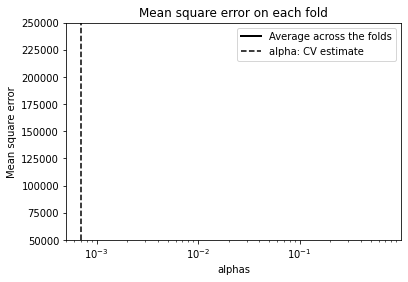

In [12]:
# Lasso path: plot results of cross-validation with mean squared error
plt.semilogx(model.alphas_, model.mse_path_, ":")
# Plot the average mean squared error across all folds for each value of alpha
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
# Add a vertical line to indicate the value of alpha chosen by the LassoCV
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

# Add legend and labels
plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# Set the y-axis limits
ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);

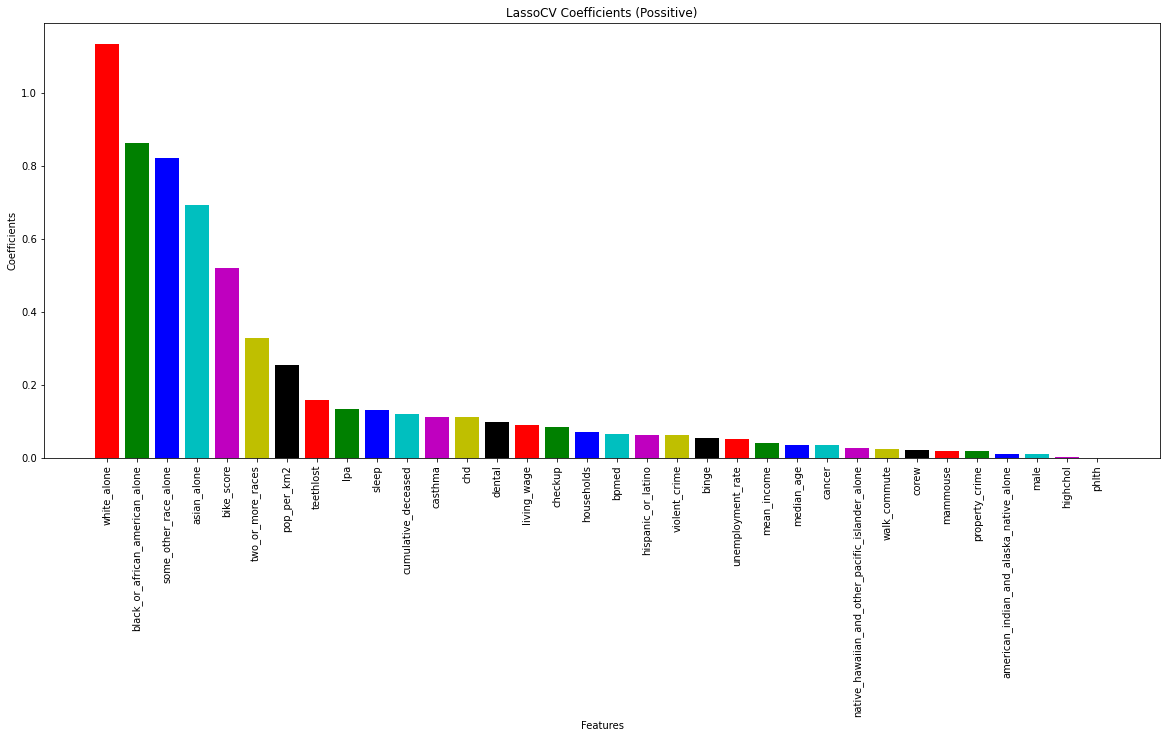

In [13]:
# Create a list of feature importance tuples for only positive coefficients 
feature_importance = [(feature, coef) for feature, coef in sorted_feature_importance if coef > 0]

# Extract the features and coefficients into separate lists
features = [f[0] for f in feature_importance]
coefs = [f[1] for f in feature_importance]

# Create a figure with width=12 inches and height=8 inches
plt.figure(figsize=(20,8))

# Create a bar plot of the feature importance with different colors for each feature
plt.bar(features, coefs, color=['r','g','b','c','m','y','k'])

plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("LassoCV Coefficients (Possitive)")
plt.xticks(rotation=90)
plt.show()